In [182]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import matplotlib.pyplot as plt
import numpy as np
import random
import struct

In [5]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [6]:
def load_mnist_data(imagesfile, labelsfile):
    images = read_idx(imagesfile)
    labels = read_idx(labelsfile)
    return images, labels

In [9]:
train_images_path = "data\\train-images.idx3-ubyte"
train_labels_path = "data\\train-labels.idx1-ubyte"
test_images_path= "data\\t10k-images.idx3-ubyte"
test_labels_path= "data\\t10k-labels.idx1-ubyte"

In [12]:
train_images, train_labels = load_mnist_data(train_images_path, train_labels_path)
test_images, test_labels = load_mnist_data(test_images_path, test_labels_path)

In [13]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [168]:
def visualize_images(images, labels):
    fig, axes = plt.subplots(5, 4, figsize=(10, 5))
    axes = axes.flatten()
    
    for i in range(20):
        axes[i].imshow(images[i])
        axes[i].set_title(labels[i])
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()

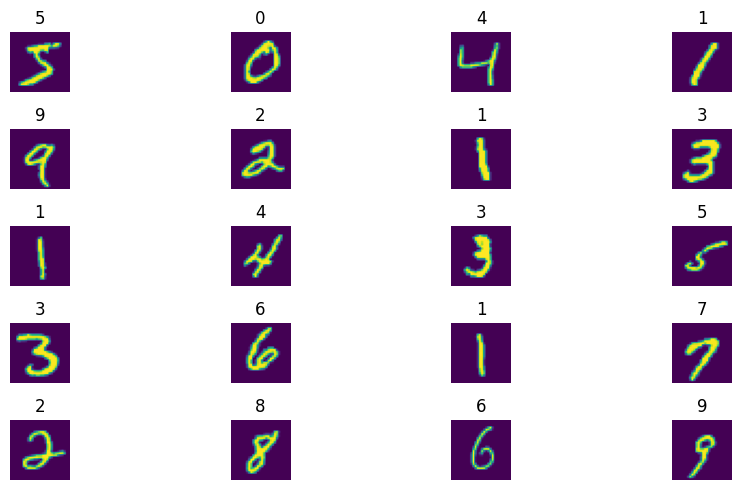

In [169]:
visualize_images(train_images, train_labels)

In [62]:
def flatten_image(images, labels):
    return images.reshape(images.shape[0], 28, 28), labels

In [128]:
Xtr, ytr = flatten_image(train_images, train_labels)
Xte, yte = flatten_image(test_images, test_labels)

In [129]:
Xtr.shape, Xte.shape

((60000, 28, 28), (10000, 28, 28))

In [109]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [183]:
torch.cuda.is_available()

False

In [172]:
class neuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(neuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, output_size)
        self.train_loss = []
        self.val_loss = []
            
    def forward(self, xin):
        x = F.relu(self.layer1(xin))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)
    
    def predict(self, x_test):
        with torch.no_grad():
            logits = self.forward(x_test)
            return torch.argmax(logits, dim=1)
    
    def estimate_loss(self, X_val, y_val):
        self.eval()
        with torch.no_grad():
            logits = self.forward(X_val)
            loss = F.cross_entropy(logits, y_val)
        self.train()
        return loss.item()
    
    def train_model(self, X_train, y_train, epochs=100, X_val=None, y_val=None):
        optimizer = torch.optim.AdamW(self.parameters(), lr=0.01)
        
        for epoch in range(epochs):
            self.train()
            logits = self.forward(X_train)
            loss = F.cross_entropy(logits, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            val_loss = self.estimate_loss(X_val, y_val) if X_val is not None and y_val is not None else None
            self.train_loss.append(loss.item())
            self.val_loss.append(val_loss)
            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}, Val_Loss: {val_loss:.4f}')

In [142]:
x = Xtr
y = ytr

x_tensor = torch.tensor(x, dtype=torch.float32).reshape(-1 ,784) / 255.0
y_tensor = torch.tensor(y, dtype=torch.long)

In [143]:
from sklearn.model_selection import train_test_split

In [144]:
X_train, X_val, y_train, y_val = train_test_split(x_tensor, y_tensor, test_size=0.2,random_state=121) 

In [145]:
X_train.shape

torch.Size([48000, 784])

In [173]:
model = neuralNetwork(784, 10)
model.train_model(X_train, y_train, epochs=100, X_val=X_val, y_val=y_val)

Epoch 1, Loss: 2.3063, Val_Loss: 2.2263
Epoch 2, Loss: 2.2208, Val_Loss: 2.0659
Epoch 3, Loss: 2.0604, Val_Loss: 1.7297
Epoch 4, Loss: 1.7201, Val_Loss: 1.5874
Epoch 5, Loss: 1.5808, Val_Loss: 1.3967
Epoch 6, Loss: 1.3888, Val_Loss: 1.0933
Epoch 7, Loss: 1.0919, Val_Loss: 0.9761
Epoch 8, Loss: 0.9878, Val_Loss: 0.8980
Epoch 9, Loss: 0.9190, Val_Loss: 0.6842
Epoch 10, Loss: 0.6967, Val_Loss: 0.7016
Epoch 11, Loss: 0.7080, Val_Loss: 0.6138
Epoch 12, Loss: 0.6209, Val_Loss: 0.5728
Epoch 13, Loss: 0.5852, Val_Loss: 0.5296
Epoch 14, Loss: 0.5423, Val_Loss: 0.4928
Epoch 15, Loss: 0.5034, Val_Loss: 0.4500
Epoch 16, Loss: 0.4583, Val_Loss: 0.4310
Epoch 17, Loss: 0.4359, Val_Loss: 0.4182
Epoch 18, Loss: 0.4200, Val_Loss: 0.3849
Epoch 19, Loss: 0.3836, Val_Loss: 0.3597
Epoch 20, Loss: 0.3557, Val_Loss: 0.3477
Epoch 21, Loss: 0.3429, Val_Loss: 0.3281
Epoch 22, Loss: 0.3243, Val_Loss: 0.3163
Epoch 23, Loss: 0.3127, Val_Loss: 0.3018
Epoch 24, Loss: 0.2965, Val_Loss: 0.2877
Epoch 25, Loss: 0.2800, V

In [174]:
x_test = torch.tensor(Xte, dtype=torch.float32).reshape(-1, 784) / 255.0
y_test = torch.tensor(yte, dtype=torch.long)

In [175]:
ypred = np.array(model.predict(x_test))

In [176]:
ypred.shape

(10000,)

In [177]:
from sklearn.metrics import mean_squared_error as mse 

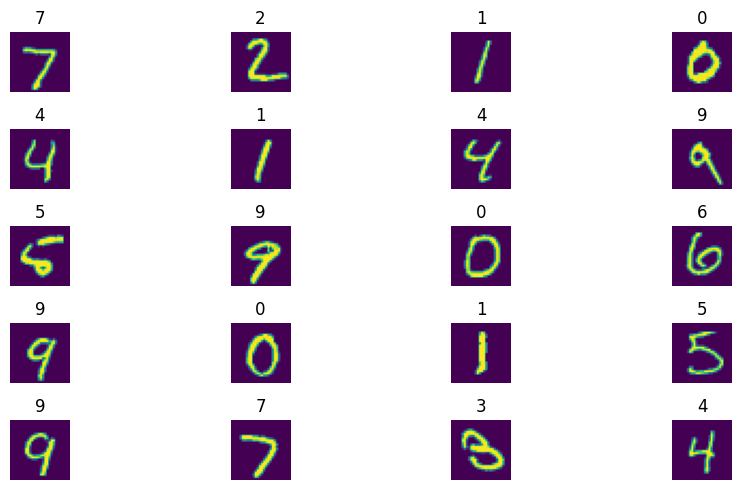

In [178]:
visualize_images(X_test, ypred)

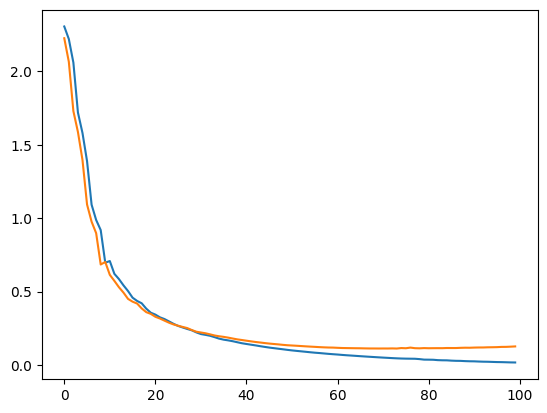

In [180]:
plt.plot(model.train_loss)
plt.plot(model.val_loss)

In [188]:
import torch

print("Torch version:",torch.__version__)

print("Is CUDA enabled?",torch.cuda.is_available())

Torch version: 2.3.1+cpu
Is CUDA enabled? False
